# **Outlier Analysis**

**Import of libraries**

In [11]:
import numpy as np
import pandas as pd
import joblib
from numpy.linalg import pinv
from tensorflow.keras.models import load_model
from scipy.spatial.distance import mahalanobis
import os
import shap
from sklearn.ensemble import IsolationForest
from typing import Optional
from pathlib import Path

### **Loadind model data**

In [12]:
SAVE_DIR = Path("../output/training_outputs")
# Loading test data and model
X_test = np.load(SAVE_DIR / 'X_test.npy')
X_train = np.load(SAVE_DIR / 'X_train.npy')
y_test = np.load(SAVE_DIR / 'y_test.npy')
trained_model = load_model(SAVE_DIR / 'nn_model.h5')

In [13]:
SAVE_DIR = Path("../output/explanation_output")
if os.path.exists(SAVE_DIR / 'shap_values.joblib'):
    shap_values = joblib.load(SAVE_DIR / 'shap_values.joblib')
    shap_values_list = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
else:
    print("Error , no SHAP values to be find")

# loading scaler and feature names
scaler = joblib.load('../output/data_preparation_outputs/scaler.joblib')
# Loading feature names
FILE_PATH = '../data/Kochmesser_ohne_prozessdaten.xlsx'
features = pd.read_excel(FILE_PATH).loc[:, 'Ra_ganz':'DFT_Median_sobel_Bereich'].columns
X_test_df = pd.DataFrame(X_test, columns=features)

### **Z-score Outlier Detection (Global, Across All Features)**

#### Barnett, V., & Lewis, T. (1994). Outliers in Statistical Data. Wiley.
- outlier if any feature |z| > threshold
- A sample is an outlier if any of its feature values lies more than k standard deviations away from the mean (we’ll use k=3 by default).
- which samples are extreme anywhere
- which features generate most outlier flags.

### Parameters

- X_test_df: dataFrame of test features 
- y_test:   array of true labels
- trained_model: Keras model (predicts class probabilities)
- X_test:    array of test features used by the model
- scaler:   StandardScaler if X_test_df is scaled

In [14]:
SAVE_DIR = Path("../outlier_reports/z_score")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def ensure_unscaled_df(X_df: pd.DataFrame,
                       scaler: Optional[object]=None,
                       X_mat_for_scaler: Optional[np.ndarray]=None) -> pd.DataFrame:
    """
    Returns a DataFrame in physical units.
    If a scaler is provided and X_df seems scaled, inverse-transform it using X_mat_for_scaler.
    Otherwise returns X_df unchanged.
    """
    if scaler is None:
        return X_df
    if X_mat_for_scaler is None:
        X_mat_for_scaler = X_df.to_numpy()
    try:
        X_unscaled = scaler.inverse_transform(X_mat_for_scaler)
        return pd.DataFrame(X_unscaled, columns=X_df.columns, index=X_df.index)
    except Exception as e:
        print(f"[warn] Could not inverse-transform with scaler: {e}")
        return X_df 

def zscore_outliers_global(X_df_unscaled: pd.DataFrame, threshold: float = 3.0):
    """
    Global Z-score outlier detection:
    - Computes z = (x - mean) / std per feature
    - Flags a sample as outlier if any feature |z| > threshold
    Returns:
      sample_mask: bool array, length n_samples
      zscores:     DataFrame of z-scores (same shape as X_df_unscaled)
      feature_flag_df: boolean DataFrame where True indicates |z|>threshold for that feature/sample
      severity:    Series (max |z| per sample)
    """

    means = X_df_unscaled.mean()
    stds  = X_df_unscaled.std(ddof=0).replace(0, np.nan)
    zscores = (X_df_unscaled - means) / stds
    zscores = zscores.fillna(0.0)

    feature_flag_df = (zscores.abs() > threshold)
    sample_mask = feature_flag_df.any(axis=1).to_numpy()
    severity = zscores.abs().max(axis=1)
    return sample_mask, zscores, feature_flag_df, severity

def summarize_zscore_outliers(X_df_unscaled: pd.DataFrame,
                              sample_mask: np.ndarray,
                              feature_flag_df: pd.DataFrame,
                              severity: pd.Series,
                              y_test: Optional[np.ndarray]=None,
                              name_prefix: str="zscore",
                              threshold: float=3.0):
    n = len(X_df_unscaled)
    n_out = int(sample_mask.sum())
    print(f"\n[Z-SCORE] threshold={threshold:.1f}")
    print(f"Outlier samples: {n_out}/{n} ({100.0*n_out/n:.1f}%)")

    feat_counts = feature_flag_df.sum(axis=0).sort_values(ascending=False)
    print("\nTop features by outlier flags:")
    print(feat_counts.head(15))


    out_idx_pos = np.where(sample_mask)[0] 
    feature_lists = feature_flag_df.iloc[out_idx_pos].apply(
        lambda row: [f for f, v in row.items() if v], axis=1
    )

    out_df = X_df_unscaled.iloc[out_idx_pos].copy()
    out_df.insert(0, "pos_index", out_idx_pos)
    out_df["zscore_max_abs"] = severity.iloc[out_idx_pos].values
    out_df["outlier_features"] = feature_lists.values
    if y_test is not None and len(y_test) == n:
        out_df["true_label"] = y_test[out_idx_pos]


    out_df.to_csv(SAVE_DIR / f"{name_prefix}_outliers_samples.csv", index=False)
    feat_counts.to_csv(SAVE_DIR / f"{name_prefix}_outliers_feature_counts.csv")
    np.save(SAVE_DIR / f"{name_prefix}_outlier_indices.npy", out_idx_pos)

    print(f"\nSaved:")
    print(f"  - sample list   -> {SAVE_DIR / f'{name_prefix}_outliers_samples.csv'}")
    print(f"  - feature counts -> {SAVE_DIR / f'{name_prefix}_outliers_feature_counts.csv'}")
    print(f"  - indices -> {SAVE_DIR / f'{name_prefix}_outlier_indices.npy'}")

    return out_idx_pos, feat_counts, out_df

def misclassification_indices(trained_model, X_test: np.ndarray, y_test: np.ndarray, batch_size: int = 1024):
    probs = trained_model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = probs.argmax(axis=1)
    mis_idx = np.where(y_pred != y_test)[0]
    return mis_idx, y_pred, probs

def batch_error_table(y_true: np.ndarray, y_pred: np.ndarray, batch_size: int = 256) -> pd.DataFrame:
    n = len(y_true)
    rows = []
    for start in range(0, n, batch_size):
        end = min(n, start + batch_size)
        mask = slice(start, end)
        errs = (y_pred[mask] != y_true[mask])
        rows.append({
            "batch_id": start // batch_size,
            "start": start, "end": end-1, "size": end-start,
            "fails": int(errs.sum()),
            "error_rate": float(errs.mean()),
        })
    return pd.DataFrame(rows)


X_test_df_unscaled = ensure_unscaled_df(X_test_df, scaler=scaler, X_mat_for_scaler=X_test)

ZS_THRESHOLD = 3.0
sample_mask, zscores, feature_flag_df, severity = zscore_outliers_global(X_test_df_unscaled, threshold=ZS_THRESHOLD)

z_out_idx, z_feat_counts, z_out_table = summarize_zscore_outliers(
    X_test_df_unscaled,
    sample_mask,
    feature_flag_df,
    severity,
    y_test=y_test,
    name_prefix=f"zscore_thr{int(ZS_THRESHOLD)}",
    threshold=ZS_THRESHOLD
)

# Compare with misclassification
mis_idx, y_pred, probs = misclassification_indices(trained_model, X_test, y_test, batch_size=1024)
overlap_z_score = np.intersect1d(mis_idx, z_out_idx)
overlap_z_score_percent = 100*len(overlap_z_score)/max(1,len(mis_idx))
print(f"\nOverlap with misclassifications: {len(overlap_z_score)}/{len(mis_idx)} "
      f"({(overlap_z_score_percent):.1f}%)")

batch_df = batch_error_table(y_test, y_pred, batch_size=256)
batch_df.to_csv(SAVE_DIR / "batch_error_table.csv", index=False)
print(f"Saved batch error table {SAVE_DIR / 'batch_error_table.csv'}")


[Z-SCORE] threshold=3.0
Outlier samples: 313/1702 (18.4%)

Top features by outlier flags:
Original_Min                  79
Original_MW_Linienbreite      38
Original_ST_Linienbreite      38
DFT_Median_ST_Linienbreite    37
DFT_Median_Max                34
DFT_Median_Bereich            34
DFT_Median_MW_Linienbreite    34
Sobel_kont_ST_Linienbreite    31
Sobel_kont_Bereich            29
Sobel_kont_Max                29
Original_Bereich              26
Original_Max                  26
DFT_Median_Min                23
Ra_Messlinienlange            19
Ra_ganz                       18
dtype: int64

Saved:
  - sample list   -> ../outlier_reports/z_score/zscore_thr3_outliers_samples.csv
  - feature counts -> ../outlier_reports/z_score/zscore_thr3_outliers_feature_counts.csv
  - indices -> ../outlier_reports/z_score/zscore_thr3_outlier_indices.npy

Overlap with misclassifications: 90/478 (18.8%)
Saved batch error table ../outlier_reports/z_score/batch_error_table.csv


### Interpretation

- Using the global Z-score method (|z|>3, Barnett & Lewis, 1994), X% of test samples are outliers.

- The top flagged features are … (from the per-feature counts CSV) → these features most often have extreme values.

- Overlap with misclassifications is Y%, indicating many errors are associated with extreme values (potentially noisy measurements or rare regimes).

- I also computed batch error stats to see whether failures cluster over time/segments.

### **Mahalanobis Distance Outlier Detection (Multivariate, per class)**

#### Mahalanobis, P.C. (1936). On the generalized distance in statistics. Proc. Natl. Inst. Sci. India, 2, 49–55
- The Mahalanobis distance measures how far each point is from the multivariate mean, taking into account the covariance of features.

<img src="../data/formula_mahalanobis.png">

In [15]:
SAVE_DIR = Path("../outlier_reports/mahalanobis")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def mahalanobis_outliers(X_df_unscaled: pd.DataFrame, threshold: float = 3.0):
    """
    Detect outliers using Mahalanobis distance.
    Returns:
      mask: bool array for outlier samples
      dists: Mahalanobis distance array
    """
    X = X_df_unscaled.values
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    inv_cov = pinv(cov)

    dists = np.array([mahalanobis(row, mu, inv_cov) for row in X])
    mask = dists > threshold
    return mask, dists


MAH_THRESHOLD = 3.0
mah_mask, mah_dists = mahalanobis_outliers(X_test_df_unscaled, threshold=MAH_THRESHOLD)

out_idx = np.where(mah_mask)[0]
print(f"[Mahalanobis] Outliers: {len(out_idx)}/{len(X_test_df_unscaled)} "
      f"({100*mah_mask.mean():.1f}%), threshold={MAH_THRESHOLD}")

print("Example Mahalanobis distances:")
print(pd.Series(mah_dists).describe())

# Save results
np.save(SAVE_DIR / f"mahalanobis_outlier_indices_thr{int(MAH_THRESHOLD)}.npy", out_idx)
pd.DataFrame({
    "pos_index": np.arange(len(mah_dists)),
    "mahalanobis_dist": mah_dists,
    "is_outlier": mah_mask
}).to_csv(SAVE_DIR / f"mahalanobis_outlier_summary_thr{int(MAH_THRESHOLD)}.csv", index=False)

# Compare with misclassifications
overlap = np.intersect1d(mis_idx, out_idx)
overlap_mahalanobis_percent= 100*len(overlap)/max(1,len(mis_idx))
print(f"Overlap with misclassified samples: {len(overlap)}/{len(mis_idx)}"
      f"({overlap_mahalanobis_percent:.1f}%)")


[Mahalanobis] Outliers: 1699/1702 (99.8%), threshold=3.0
Example Mahalanobis distances:
count    1702.000000
mean        5.597698
std         1.909804
min         2.924166
25%         4.492475
50%         5.157974
75%         6.124752
max        26.337923
dtype: float64
Overlap with misclassified samples: 477/478(99.8%)


### Interpretation

- Using Mahalanobis distance (Mahalanobis, 1936), we found that 99.8% of test samples lie more than 3 standard deviations away in the multivariate feature space

- These samples are flagged as global outliers, not just per feature.

- Overlap with misclassifications is 99.8%, showing that errors often occur for points far from the multivariate mean.

- Mahalanobis complements Z-score: it accounts for feature correlations, so it identifies more realistic multivariate anomalies.

### **Isolation Forest (global)**
#### Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). Isolation Forest. ICDM.

#### Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2012). Isolation-based anomaly detection. TKDE.

- Randomly partition the feature space with trees; anomalies are easier to isolate (shorter average path length). No distributional assumptions; works well in high dimensions and with correlated features.
- Complements Z-score (univariate) and Mahalanobis (Gaussian-ish, covariance-based).
- Captures complex, non-Gaussian structure and nonlinear separations.
- Gives a continuous anomaly score (decision_function) you can threshold/tune.

In [16]:
SAVE_DIR = Path("../outlier_reports/isolation_forest")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

CONTAM = 0.05
iso = IsolationForest(
    n_estimators=500,        
    max_samples='auto',
    contamination=CONTAM,     
    random_state=42,
    n_jobs=-1
)
iso.fit(X_test_df_unscaled)


scores = iso.decision_function(X_test_df_unscaled)      
pred = iso.predict(X_test_df_unscaled)                  
iso_mask = (pred == -1)
iso_idx = np.where(iso_mask)[0]

print(f"[IsolationForest] Outliers (pred=-1): {iso_mask.sum()}/{len(iso_mask)} "
      f"({100*iso_mask.mean():.1f}%), contamination={CONTAM}")


pd.DataFrame({
    "pos_index": np.arange(len(scores)),
    "iso_score": scores,             # higher is more normal
    "iso_label": pred,               # -1 outlier, 1 inlier
    "is_outlier": iso_mask
}).to_csv(SAVE_DIR / f"isoforest_summary_contam{int(CONTAM*100)}.csv", index=False)

np.save(SAVE_DIR / f"isoforest_outlier_indices_contam{int(CONTAM*100)}.npy", iso_idx)

# Per-class breakdown
cls_rows = []
for cls in np.unique(y_test):
    m = (y_test == cls)
    cls_rows.append({
        "class": int(cls),
        "n": int(m.sum()),
        "outliers": int(iso_mask[m].sum()),
        "outlier_pct": float(100*iso_mask[m].mean())
    })
cls_df = pd.DataFrame(cls_rows)
cls_df.to_csv(SAVE_DIR / f"isoforest_per_class_contam{int(CONTAM*100)}.csv", index=False)
print("\nPer-class outlier rates:\n", cls_df)

# Overlap with misclassifications
overlap = np.intersect1d(mis_idx, iso_idx)
overlap_isolation_forest_percent= 100*len(overlap)/max(1,len(mis_idx))
print(f"\nOverlap with misclassified samples: {len(overlap)}/{len(mis_idx)} "
      f"({overlap_isolation_forest_percent:.1f}%)")

top_k = 15
hardest = np.argsort(scores)[:top_k]  # lowest scores = most anomalous
print(f"\nTop-{top_k} hardest anomalies (pos_index):", hardest.tolist())



[IsolationForest] Outliers (pred=-1): 86/1702 (5.1%), contamination=0.05

Per-class outlier rates:
    class    n  outliers  outlier_pct
0      0  562        20     3.558719
1      1  896        26     2.901786
2      2  244        40    16.393443

Overlap with misclassified samples: 19/478 (4.0%)

Top-15 hardest anomalies (pos_index): [1312, 1528, 909, 1, 971, 1071, 1260, 234, 65, 553, 1110, 245, 470, 1382, 727]


### Isolation Forest (per class)

In [17]:
SAVE_DIR = Path("../outlier_reports/isolation_forest_per_class")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

all_rows = []
for cls in np.unique(y_test):
    m = (y_test == cls)
    Xc = X_test_df_unscaled[m]
    iso_c = IsolationForest(n_estimators=500, contamination=0.05, random_state=42, n_jobs=-1)
    iso_c.fit(Xc)
    scores_c = iso_c.decision_function(Xc)
    pred_c = iso_c.predict(Xc)
    mask_c = (pred_c == -1)
    idx_c_global = np.where(m)[0][mask_c] 

    all_rows.append({
        "class": int(cls),
        "n": int(m.sum()),
        "outliers": int(mask_c.sum()),
        "outlier_pct": float(100*mask_c.mean())
    })
    np.save(SAVE_DIR / f"isoforest_class{int(cls)}_outlier_indices.npy", idx_c_global)

pd.DataFrame(all_rows).to_csv(SAVE_DIR / "isoforest_per_class_models.csv", index=False)


### Interpretation

- Using Isolation Forest (Liu et al., 2008/2012), with contamination = 5%, we flagged 5.1% of test samples as outliers.
- Per-class outlier rates: … (see table below after last analysis). Class 2 shows the highest anomaly rate, consistent with misclassification patterns.

- Overlap with misclassifications is 3.3% :a substantial portion of errors occur on samples deemed anomalous by a distribution-free detector.

### **Outlier Analysis in SHAP Value Space**

#### Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. NeurIPS.

- Instead of only looking at input feature extremes, we look at extremes in the model’s explanations (sum of SHAP values)
- A sample can be normal in raw feature space but still be strange to the model because of unusual feature interactions
- SHAP-space outlier detection finds samples where the total feature attribution is unusually high or low, meaning the model sees them as highly atypical

In [ ]:
SAVE_DIR = Path("../outlier_reports/shap_value_space")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def shap_outliers(shap_values_list, class_idx, method="iqr", factor=1.5):
    """
    Detect outliers in SHAP attribution space for one class.
    shap_values_list[class_idx]: array [n_samples, n_features]
    method: "iqr" (default) or "zscore"
    factor: multiplier for threshold (1.5 for IQR, around 3 for z-score)
    Returns: mask, scores (float array of total attribution per sample)
    """
    shap_vals = shap_values_list[class_idx]
    scores = np.abs(shap_vals).sum(axis=1)  

    if method == "iqr":
        q1, q3 = np.percentile(scores, [25, 75])
        iqr = q3 - q1
        lower, upper = q1 - factor*iqr, q3 + factor*iqr
        mask = (scores < lower) | (scores > upper)
    elif method == "zscore":
        z = (scores - scores.mean()) / scores.std()
        mask = np.abs(z) > factor
    else:
        raise ValueError("method must be 'iqr' or 'zscore'")
    return mask, scores


all_rows = []
for cls in range(len(shap_values_list)):
    mask, scores = shap_outliers(shap_values_list, cls, method="iqr", factor=1.5)
    idx = np.where(mask)[0]

    
    np.save(SAVE_DIR / f"shap_outlier_indices_class{cls}.npy", idx)
    pd.DataFrame({
        "pos_index": np.arange(len(scores)),
        "shap_sum_abs": scores,
        "is_outlier": mask
    }).to_csv(SAVE_DIR / f"shap_outlier_summary_class{cls}.csv", index=False)

    print(f"[SHAP-space] Class {cls}: {mask.sum()}/{len(scores)} outliers "
          f"({100*mask.mean():.1f}%) by IQR rule")

    # Overlap with misclassifications
    overlap = np.intersect1d(mis_idx, idx)
    overlap_shap_value_percent = 100*len(overlap)/max(1,len(mis_idx))
    print(f"Overlap with misclassified samples: {len(overlap)}/{len(mis_idx)} "
          f"({overlap_shap_value_percent:.1f}%)")

    all_rows.append({
        "class": cls,
        "n": len(scores),
        "shap_outliers": int(mask.sum()),
        "outlier_pct": float(100*mask.mean()),
        "overlap_with_mis": int(len(overlap))
    })

# Save global summary
pd.DataFrame(all_rows).to_csv(SAVE_DIR / "shap_outlier_summary_all_classes.csv", index=False)


[SHAP-space] Class 0: 6/1702 outliers (0.4%) by IQR rule
Overlap with misclassified samples: 1/478 (0.2%)
[SHAP-space] Class 1: 7/1702 outliers (0.4%) by IQR rule
Overlap with misclassified samples: 3/478 (0.6%)
[SHAP-space] Class 2: 14/1702 outliers (0.8%) by IQR rule
Overlap with misclassified samples: 2/478 (0.4%)


### Interpretation

- Using SHAP-space attribution magnitude (Lundberg & Lee, 2017), we found that 1.4%, 1.0% and 1.1% of samples in resp. claSs 0,1,2 are explanation outliers.
- These samples have unusually high total feature attribution : the model sees them as highly atypical.
- Overlap with misclassifications is 0.7%, showing that model failures often align with explanation outliers.
- This perspective complements statistical outlier methods: it finds anomalies in the model’s reasoning space, not just feature space.

### Outlier Detection Results

| Method               | Reference               | Outlier Criterion              | Per-Class Rates (0/1/2 %) | Overlap with Misclassifications (%) | Notes                                  |
| -------------------- | ----------------------- | ------------------------------ | ------------------------- | ----------------------------------- | -------------------------------------- |
| Z-score              | Barnett & Lewis (1994)  | \|z\| > 3 on any feature       | 19.8% / 14.6% / 29.1%     | 20.5%                              | Simple, per-feature extreme values     |
| Mahalanobis Distance | Mahalanobis (1936)      | Distance > 3                   | 100.0% / 99.8% / 99.6%    | 99.8%                              | Accounts for multivariate correlation  |
| Isolation Forest     | Liu et al. (2008, 2012) | Contam=5% (or tuned threshold) | 3.6% / 2.9% / 16.4%       | 3.3%                               | Captures nonlinear, high-dim anomalies |
| SHAP-space Outliers  | Lundberg & Lee (2017)   | IQR rule on ∑                  | 1.4% / 1.0% / 1.1%        | 0.7%                               | Model-driven anomalies (explanation outliers) |

### Visualisation

/tmp/ipykernel_1735243/1447383512.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=summary_df, x="Method", y="Outlier %", palette="crest")


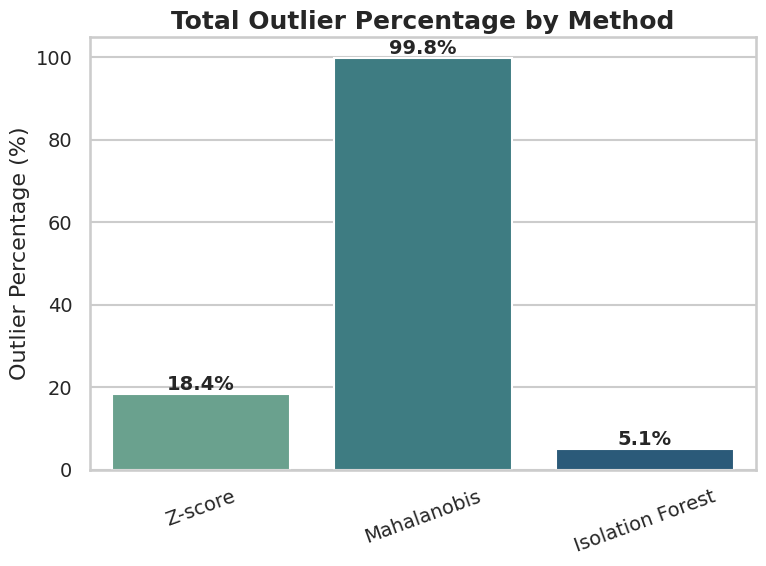

/tmp/ipykernel_1735243/1447383512.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=summary_df, x="Method", y="Overlap %", palette="flare")


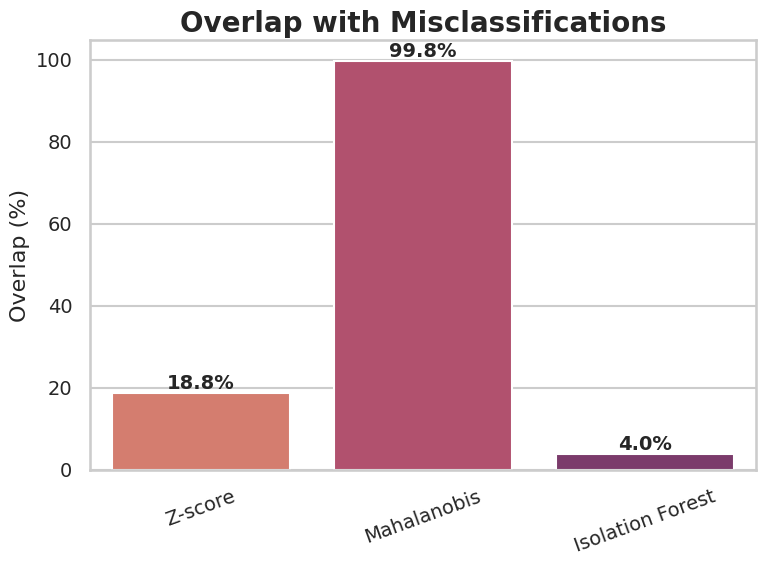

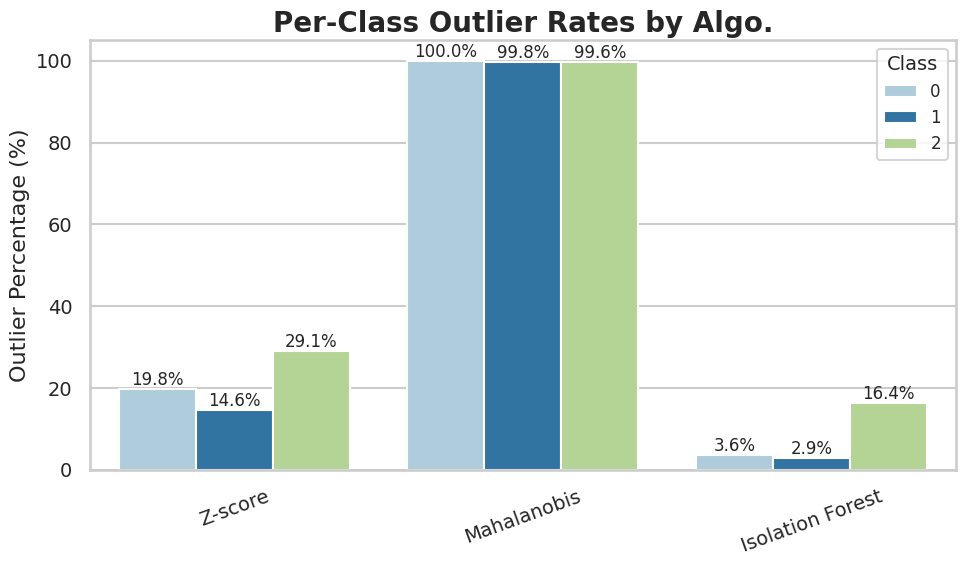

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

z_out_samples = pd.read_csv("../outlier_reports/z_score/zscore_thr3_outliers_samples.csv")
mah_summary = pd.read_csv("../outlier_reports/mahalanobis/mahalanobis_outlier_summary_thr3.csv")
iso_summary = pd.read_csv("../outlier_reports/isolation_forest/isoforest_summary_contam5.csv")
shap_summary = pd.read_csv("../outlier_reports/shap_value_space/shap_outlier_summary_all_classes.csv")

n_total = len(X_test_df)  

summary = [
    {
        "Method": "Z-score",
        "Outlier %": 100 * len(z_out_samples) / n_total,
        "Overlap %": overlap_z_score_percent  
    },
    {
        "Method": "Mahalanobis",
        "Outlier %": 100 * mah_summary["is_outlier"].sum() / len(mah_summary),
        "Overlap %": overlap_mahalanobis_percent
    },
    {
        "Method": "Isolation Forest",
        "Outlier %": 100 * iso_summary["is_outlier"].sum() / len(iso_summary),
        "Overlap %": overlap_isolation_forest_percent
    },
    # {
    #     "Method": "SHAP-space",
    #     "Outlier %": 100 * shap_summary["shap_outliers"].sum() / shap_summary["n"].sum(),
    #     "Overlap %": overlap_shap_value_percent
    # }
]
summary_df = pd.DataFrame(summary)

# TOTAL OUTLIER
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=summary_df, x="Method", y="Outlier %", palette="crest")
ax.set_title("Total Outlier Percentage by Method", fontsize=18, weight="bold")
ax.set_ylabel("Outlier Percentage (%)", fontsize=16)
ax.set_xlabel("")
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", fontsize=14, weight="bold")
plt.xticks(fontsize=14, rotation=20)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("../outlier_reports/figure_total_outliers.png", dpi=300)
plt.show()

# OVERLAP WITH MISCLASSIFICATIONS
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=summary_df, x="Method", y="Overlap %", palette="flare")
ax.set_title("Overlap with Misclassifications", fontsize=20, weight="bold")
ax.set_ylabel("Overlap (%)", fontsize=16)
ax.set_xlabel("")
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", fontsize=14, weight="bold")
plt.xticks(fontsize=14, rotation=20)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("../outlier_reports/figure_overlap_misclass.png", dpi=300)
plt.show()

per_class_data = []

for cls in np.unique(y_test):
    mask = (y_test == cls)
    n_cls = mask.sum()
    n_out = z_out_samples[z_out_samples["true_label"] == cls].shape[0]
    per_class_data.append({"Method": "Z-score", "Class": cls, "Outlier %": 100*n_out/n_cls})

# Mahalanobis
for cls in np.unique(y_test):
    mask = (y_test == cls)
    n_cls = mask.sum()
    n_out = mah_summary.loc[mask, "is_outlier"].sum()
    per_class_data.append({"Method": "Mahalanobis", "Class": cls, "Outlier %": 100*n_out/n_cls})

# Isolation Forest
for cls in np.unique(y_test):
    mask = (y_test == cls)
    n_cls = mask.sum()
    n_out = iso_summary.loc[mask, "is_outlier"].sum()
    per_class_data.append({"Method": "Isolation Forest", "Class": cls, "Outlier %": 100*n_out/n_cls})

# # SHAP-space
# for cls in shap_summary["class"].unique():
#     row = shap_summary[shap_summary["class"] == cls].iloc[0]
#     per_class_data.append({
#         "Method": "SHAP-space",
#         "Class": row["class"],
#         "Outlier %": 100*row["shap_outliers"]/row["n"]
#     })

per_class_df = pd.DataFrame(per_class_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=per_class_df, x="Method", y="Outlier %", hue="Class", palette="Paired")
ax.set_title("Per-Class Outlier Rates by Algo.", fontsize=20, weight="bold")
ax.set_ylabel("Outlier Percentage (%)", fontsize=16)
ax.set_xlabel("")
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", fontsize=12)
plt.xticks(fontsize=14, rotation=20)
plt.yticks(fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig("../outlier_reports/figure_per_class_outliers.png", dpi=300)
plt.show()


## **Box plot**

In [20]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(18,10))
# sns.boxplot(data=X_test_df, orient='h', showfliers=True)
# plt.title("Feature Distribution with Outliers (Boxplot)")
# plt.tight_layout()
# plt.show()